In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FactorAnalysis
import glob
from sncosmo.salt2utils import BicubicInterpolator
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import sncosmo
from scipy.interpolate import interp1d
from numpy import random
import pickle as pk
from astropy.table import Table
from sncosmo.constants import HC_ERG_AA
from sklearn import preprocessing

SCALE_FACTOR = 1e-12

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

In [2]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

In [3]:
p_grid=np.arange(-10,51,1)
w_grid1=np.arange(3350,8710,10)
w_grid2=np.arange(3400,8410,10)

In [4]:
fname=[]
for file in glob.glob("./final_SEDs/*.dat"):
    fname.append(file.split("/")[2].split(".")[0])

In [5]:
len(fname)

169

In [6]:
exclude=["Train_SN93_SED","Test_SN15_SED","Test_SN26_SED","Train_SN30_SED","Train_SN96_SED"]

In [7]:
data=[]
sne_names=[]
for sn in fname:
    if sn not in exclude:
        data.append(pd.read_csv(f"./final_SEDs/{sn}.dat")["flux"].values)
        sne_names.append(sn)

In [8]:
len(data)

164

## Applying FA

In [9]:
train_data, test_data, train_names, test_names=train_test_split(data,sne_names,test_size=0.1,random_state=0)

In [10]:
Means=np.mean(train_data,axis=1)

In [11]:
mean_cor_data=[train_data[i]-Means[i] for i in range(len(train_data))]

In [12]:
training_data=np.array(mean_cor_data).T

In [13]:
fa3_no_rot = FactorAnalysis(10)
fa3_quartimax = FactorAnalysis(10,rotation="quartimax")
fa3_varimax = FactorAnalysis(10,rotation="varimax")

In [14]:
factors_no_rot=fa3_no_rot.fit_transform(training_data)
factors_quartimax=fa3_quartimax.fit_transform(training_data)
factors_varimax=fa3_varimax.fit_transform(training_data)

In [15]:
fa_loadings_no_rot = fa3_no_rot.components_.T
fa_loadings_quartimax = fa3_quartimax.components_.T
fa_loadings_varimax = fa3_varimax.components_.T

total_var = np.sum(np.var(training_data,axis=0))

In [16]:
var_exp_no_rot = np.sum(fa_loadings_no_rot**2, axis=0)
var_exp_quartimax = np.sum(fa_loadings_quartimax**2, axis=0)
var_exp_varimax = np.sum(fa_loadings_varimax**2, axis=0)

prop_var_exp_no_rot = var_exp_no_rot/total_var
prop_var_exp_quartimax = var_exp_quartimax/total_var
prop_var_exp_varimax = var_exp_varimax/total_var

cum_prop_var_exp_no_rot = np.cumsum(var_exp_no_rot/total_var)
cum_prop_var_exp_quartimax = np.cumsum(var_exp_quartimax/total_var)
cum_prop_var_exp_varimax = np.cumsum(var_exp_varimax/total_var)

In [17]:
Mean_transformed_no_rot=fa3_no_rot.transform(Means.reshape(1, -1))
Mean_transformed_quartimax=fa3_quartimax.transform(Means.reshape(1, -1))
Mean_transformed_varimax=fa3_varimax.transform(Means.reshape(1, -1))

In [18]:
cum_prop_var_exp_no_rot

array([0.960566  , 0.97292537, 0.97990854, 0.98377678, 0.98578797,
       0.98776887, 0.98852618, 0.98927528, 0.99020683, 0.99076818])

In [19]:
cum_prop_var_exp_quartimax

array([0.95644632, 0.97016761, 0.98023999, 0.98427092, 0.98557865,
       0.98699656, 0.98796737, 0.98908523, 0.99014133, 0.99076818])

In [20]:
cum_prop_var_exp_varimax

array([0.93573825, 0.936777  , 0.96887512, 0.97377339, 0.98208102,
       0.98715118, 0.98869928, 0.98933968, 0.99017794, 0.99076818])

In [21]:
pca_exp_var=np.array([9.63007665e-01, 1.26885215e-02, 6.46318317e-03, 3.75066862e-03,
       1.87427791e-03, 1.35020458e-03, 1.08028617e-03, 9.00751722e-04,
       7.65903724e-04, 6.87471676e-04])

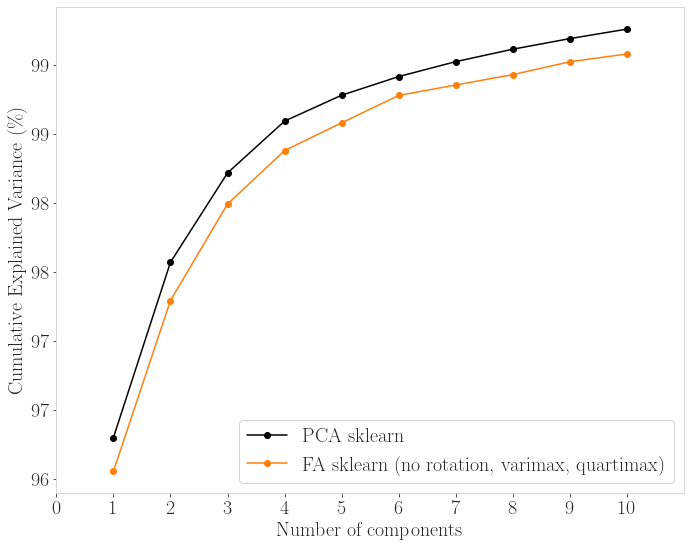

In [22]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(np.linspace(1,10,10),np.cumsum(pca_exp_var),"-o",c="black",label="PCA sklearn")
ax.plot(np.linspace(1,10,10),cum_prop_var_exp_no_rot,"-o",c="#ff7f0e",label="FA sklearn (no rotation, varimax, quartimax)")
ax.set_xlim(0,11)
ax.set_xticks(np.arange(11))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative Explained Variance (\%)");
ax.legend()

fig.tight_layout()
plt.savefig('./fa/sk_cumulative_exp_variance_comparison.pdf')  